Dataset saved locally in the data folder

In [21]:
from pathlib import Path
import pandas as pd

project_root = Path.cwd().parent 
data_path = Path("/home/alyona/personal_projects/foil_case_study/data/transactions.csv")

df = pd.read_csv(data_path, parse_dates=["InvoiceDate"])
print(f'Cleaned dataset is ready. It has {df.shape[0]} rows and {df.shape[1]} columns')

Cleaned dataset is ready. It has 358277 rows and 8 columns


# Column types and missing values

In [22]:
df.info()          

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358277 entries, 0 to 358276
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    358277 non-null  int64         
 1   StockCode    358277 non-null  int64         
 2   Description  358277 non-null  object        
 3   Quantity     358277 non-null  int64         
 4   InvoiceDate  358277 non-null  datetime64[ns]
 5   UnitPrice    358277 non-null  float64       
 6   CustomerID   358277 non-null  int64         
 7   Country      358277 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 21.9+ MB


Overall observations:
- Column types:
    - Object (2): Description, Country
    - Numeric - float (1): UnitPrice 
    - Numeric - int64 (5): InvoiceNo, StockCode,  Quantity,  CustomerID 
    - Datetime - 1: InvoiceDate 
- Memory usage: 31.9 MB

In [24]:
print('Missing values per column count')
print(df.isnull().sum())

Missing values per column count
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


Missing values observation - there are no missing values in the dataset


Completeness check

In [25]:
overall_completeness = df.notnull().sum().sum() / df.size * 100
print(f"Overall completeness measuring all data points: {overall_completeness:.2f}%")


Overall completeness measuring all data points: 100.00%


Duplicates check

In [26]:
duplicate_count = df.duplicated().sum()
print(f"Number of completely duplicated rows: {duplicate_count}")

Number of completely duplicated rows: 0


# Anomalies investigation

In [29]:
numeric_cols = ["Quantity", "UnitPrice"]
df[numeric_cols].describe()

,Quantity,UnitPrice
count,358277.000000,358277.000000
mean,13.227475,2.892641
std,188.617674,4.383010
min,1.000000,0.040000
25%,2.000000,1.250000
50%,6.000000,1.790000
75%,12.000000,3.750000
max,80995.000000,649.500000


Anomalies observation on numerical columns:
- Quantity: mean is 13, but the standard deviation is huge (188!), and max is 80,995. That’s a massive outlier—likely a data error or a bulk/cancelled order you might want to flag.
- UnitPrice: mean around £2.89, max £649.50—again, probably a few very expensive items skewing the max.

Next Steps:
Outlier detection for high Quantity and UnitPrice values: You might want to cap or filter extreme outliers.

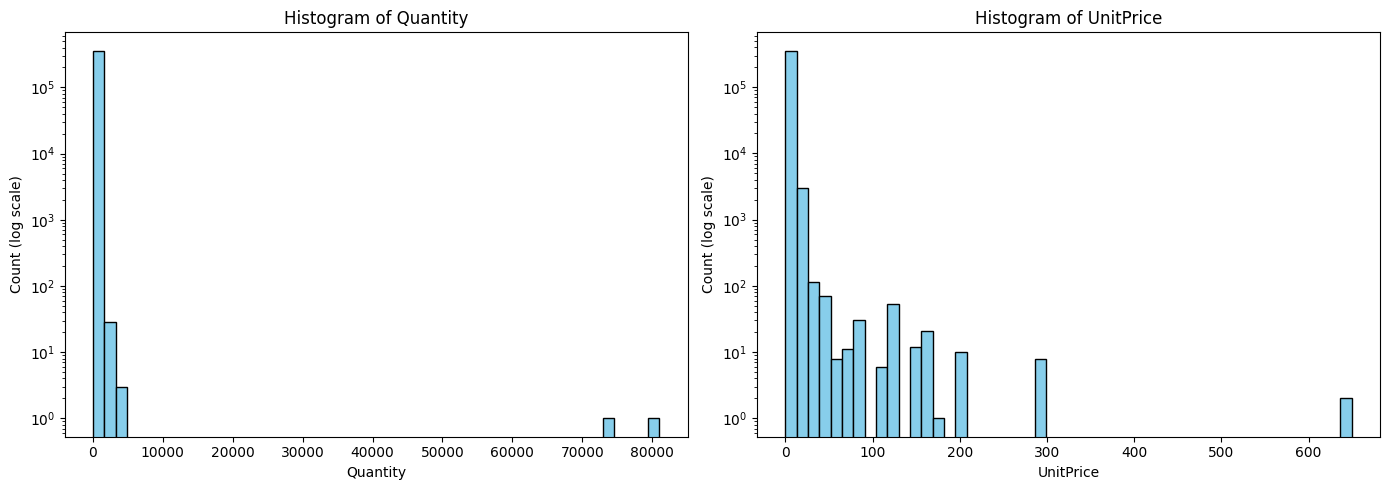

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

data_path = "/home/alyona/personal_projects/foil_case_study/data/transactions.csv"
df = pd.read_csv(data_path, parse_dates=["InvoiceDate"])

numeric_cols = ["Quantity", "UnitPrice"]

plt.figure(figsize=(14, 5))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, 2, i)
    plt.hist(df[col], bins=50, color='skyblue', edgecolor='black', log=True)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Count (log scale)")

plt.tight_layout()
plt.show()

In [ ]:
high_unit_price_threshold = 250
outliers = df[df["UnitPrice"] > high_unit_price_threshold]

print("Transactions with unusually high unit prices:")
print(outliers)

Transactions with unusually high unit prices:
        InvoiceNo  StockCode                     Description  Quantity  \
3200       536835      22655     VINTAGE RED KITCHEN CABINET         1   
18697      539080      22655     VINTAGE RED KITCHEN CABINET         1   
27804      540647      22655     VINTAGE RED KITCHEN CABINET         1   
44693      543253      22655     VINTAGE RED KITCHEN CABINET         1   
68239      546480      22656    VINTAGE BLUE KITCHEN CABINET         1   
78160      547814      22656    VINTAGE BLUE KITCHEN CABINET         1   
102707     551393      22656    VINTAGE BLUE KITCHEN CABINET         1   
126576     554836      22655     VINTAGE RED KITCHEN CABINET         1   
137807     556444      22502  PICNIC BASKET WICKER 60 PIECES        60   
137808     556446      22502  PICNIC BASKET WICKER 60 PIECES         1   

               InvoiceDate  UnitPrice  CustomerID         Country  
3200   2010-12-02 18:06:00      295.0       13145  United Kingdom  
186

Observations on High Unit Price Transactions

- Most high-priced transactions involve **VINTAGE RED/BLUE KITCHEN CABINETS** priced at £295 each.
- There are two transactions for **PICNIC BASKET WICKER 60 PIECES** priced at £649.5 each, which makes sense if it's price per 60 baskets
- Quantity is usually 1, except for one basket transaction with 60 units - need to check if this transaction was cancelled
- These appear to be legitimate high-value items rather than errors

In [53]:
high_qty_threshold = 5000
outliers = df[df["Quantity"] > high_qty_threshold]

print("Transactions with unusually high quantities:")
print(outliers)

Transactions with unusually high quantities:
        InvoiceNo  StockCode                     Description  Quantity  \
32261      541431      23166  MEDIUM CERAMIC TOP STORAGE JAR     74215   
357850     581483      23843     PAPER CRAFT , LITTLE BIRDIE     80995   

               InvoiceDate  UnitPrice  CustomerID         Country  
32261  2011-01-18 10:01:00       1.04       12346  United Kingdom  
357850 2011-12-09 09:15:00       2.08       16446  United Kingdom  


Observations on High-Quantity Transactions

- Two transactions stand out with extremely high quantities:
  1. **MEDIUM CERAMIC TOP STORAGE JAR** – 74,215 units at £1.04 each.
  2. **PAPER CRAFT, LITTLE BIRDIE** – 80,995 units at £2.08 each.
- Both transactions are for **UK customers**.
- The quantities are unusually high compared to typical orders (median quantity is 6), suggesting potential **data entry errors** or **bulk/warehouse-level transactions**.
- These outliers should be reviewed before any analytical aggregation or reporting to avoid skewing results.
